In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle


In [2]:
def loadDataFiles():
    market_df = pickle.load(open('Market_train',"rb"))
    news_df = pickle.load(open("News_train", "rb"))
    print('Finished loading datafiles!')
    return market_df, news_df


In [3]:
def preprocess_data(mkt_df, news_df, mktdropfeatures, newsdropfeatures):
    mkt_df['time'] = pd.to_datetime(mkt_df['time'])
    news_df['time'] = pd.to_datetime(news_df['time'])
    mkt_df['time'] = mkt_df['time'].dt.date
    news_df['time'] = news_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_df.drop(irrelevantColumns, axis=1, inplace=True)
    news_df.drop(newsdropfeatures, axis=1, inplace=True)
    mktdropfeatures.append('assetName')
    mkt_df.drop(mktdropfeatures, axis=1, inplace=True)
    modifiednews = news_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    print('Finished preprocessing data!')
    return merged


In [4]:
market_data, news_data = loadDataFiles()


Finished loading datafiles!


In [5]:
mkt_drop_features = ['universe', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevRaw10']
news_drop_features = []
X = preprocess_data(market_data, news_data,)


Finished preprocessing data!


In [6]:
def normalizeY(ydf):
    ydf = (ydf + 1) / 2
    return ydf


In [7]:
X = X[X['returnsOpenNextMktres10'] >=-1]
X = X[X['returnsOpenNextMktres10'] <=1]

y = X['returnsOpenNextMktres10']

X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)
assetCodesAndTime = X.iloc[:, :2]
X = X.iloc[:, 2:]

-0.9987179121017122
0.9988220255803867
normalized
0.0006410439491438824
0.9994110127901934
(4072203, 35)


In [9]:
def regularize(df):
    for column in df:
        colmin = np.amin(df[column])
        colmax = np.amax(df[column])
        df[column] = (df[column] - colmin) / (colmax - colmin)
        print(df[column])
    return df


In [18]:
def getNNModel(numhiddenlayers=2, nodes=4, numfeatures): # returns NN given hidden layers and nodes
    layers = []
    layers.append(keras.layers.Flatten(input_shape=(numfeatures,)))

    for x in range(numhiddenlayers):
        layers.append(keras.layers.Dense(nodes, activation=tf.nn.relu, use_bias=True))

    layers.append(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model = keras.Sequential(layers)
    sgd = keras.optimizers.SGD(lr=.1)
    model.compile(optimizer=sgd,
              loss='mean_squared_error',
              metrics=['accuracy'])
    return model


In [12]:
X = regularize(X)

0          0.002125
1          0.001672
2          0.000949
3          0.019357
4          0.000985
5          0.001351
6          0.000967
7          0.000246
8          0.004640
9          0.000328
10         0.007367
11         0.001121
12         0.001334
13         0.000208
14         0.001061
15         0.000505
16         0.000332
17         0.000244
18         0.003803
19         0.002013
20         0.003046
21         0.016840
22         0.002762
23         0.002416
24         0.001544
25         0.000831
26         0.000152
27         0.000480
28         0.000222
29         0.000288
             ...   
4072926    0.001722
4072927    0.000174
4072928    0.000111
4072929    0.000489
4072930    0.007432
4072931    0.000957
4072932    0.000540
4072933    0.000774
4072934    0.000553
4072935    0.000527
4072936    0.002020
4072937    0.005244
4072938    0.000632
4072939    0.000801
4072940    0.000389
4072941    0.001538
4072942    0.000795
4072943    0.000538
4072944    0.000717


0          0.067414
1          0.067414
2          0.067414
3          0.067414
4          0.067414
5          0.067414
6          0.067414
7          0.067414
8          0.067414
9          0.067414
10         0.067414
11         0.067414
12         0.067414
13         0.067414
14         0.067414
15         0.067414
16         0.067414
17         0.067414
18         0.067414
19         0.067414
20         0.067414
21         0.067414
22         0.067414
23         0.067414
24         0.067414
25         0.067414
26         0.067414
27         0.067414
28         0.067414
29         0.067414
             ...   
4072926    0.067652
4072927    0.064412
4072928    0.067735
4072929    0.067027
4072930    0.067571
4072931    0.065111
4072932    0.066201
4072933    0.066885
4072934    0.067464
4072935    0.067150
4072936    0.068313
4072937    0.067730
4072938    0.067630
4072939    0.068359
4072940    0.063608
4072941    0.067399
4072942    0.066925
4072943    0.066913
4072944    0.067048


0          0.013100
1          0.001334
2          0.000000
3          0.000000
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.005822
9          0.000000
10         0.000000
11         0.000000
12         0.007035
13         0.000000
14         0.000000
15         0.000000
16         0.000000
17         0.000000
18         0.016012
19         0.012009
20         0.000000
21         0.015688
22         0.000000
23         0.000000
24         0.000000
25         0.000000
26         0.000000
27         0.000000
28         0.000000
29         0.001456
             ...   
4072926    0.000000
4072927    0.000000
4072928    0.000000
4072929    0.000000
4072930    0.000000
4072931    0.001456
4072932    0.000000
4072933    0.000000
4072934    0.000000
4072935    0.000000
4072936    0.000000
4072937    0.000000
4072938    0.000000
4072939    0.000000
4072940    0.000000
4072941    0.000000
4072942    0.000000
4072943    0.000000
4072944    0.000000


0          0.000000
1          0.004077
2          0.000000
3          0.000000
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11         0.000000
12         0.003336
13         0.000000
14         0.000000
15         0.000000
16         0.000000
17         0.000000
18         0.000000
19         0.000000
20         0.000000
21         0.003583
22         0.000000
23         0.000000
24         0.000000
25         0.000000
26         0.000000
27         0.000000
28         0.000000
29         0.000000
             ...   
4072926    0.000000
4072927    0.000000
4072928    0.000000
4072929    0.000000
4072930    0.000000
4072931    0.000000
4072932    0.000000
4072933    0.000000
4072934    0.000000
4072935    0.000000
4072936    0.000000
4072937    0.000000
4072938    0.000000
4072939    0.000000
4072940    0.000000
4072941    0.000000
4072942    0.000000
4072943    0.000000
4072944    0.000000


0          0.002693
1          0.013210
2          0.000000
3          0.000000
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.003655
9          0.000000
10         0.000000
11         0.000000
12         0.001860
13         0.000000
14         0.000000
15         0.000000
16         0.000000
17         0.000000
18         0.002309
19         0.000962
20         0.000000
21         0.007695
22         0.000000
23         0.000000
24         0.000000
25         0.000000
26         0.000000
27         0.000000
28         0.000000
29         0.000000
             ...   
4072926    0.000000
4072927    0.000000
4072928    0.000000
4072929    0.000000
4072930    0.000000
4072931    0.004040
4072932    0.000000
4072933    0.000000
4072934    0.000000
4072935    0.000000
4072936    0.000000
4072937    0.000000
4072938    0.000000
4072939    0.000000
4072940    0.000000
4072941    0.000000
4072942    0.000000
4072943    0.000000
4072944    0.000000


In [19]:
nnmodel = getNNModel(3, 15)
nnmodel.fit(X, y, epochs=1, verbose=1, batch_size=1000000)
nnpredictions = nnmodel.predict(X)


Epoch 1/1
4072203/4072203 [==============================] - 10s 2us/step - loss: 0.0014 - acc: 0.0000e+00


In [23]:
def lossMatrix():
    layers = [3, 4, 5]
    nodes = [10, 15, 20]
    lossmatrix = []
    for layer in layers:
        lossforlayer = []
        for node in nodes:
            nnmodel2 = getNNModel(layer, node)
            nnmodel2.fit(X,y, epochs=1, verbose=1, batch_size=1000000)
            loss, acc = nnmodel2.evaluate(X, y)
            lossforlayer.append(loss)
        lossmatrix.append(lossforlayer)
    print(lossmatrix)

Epoch 1/1
4072203/4072203 [==============================] - 54s 13us/step
Epoch 1/1
4072203/4072203 [==============================] - 57s 14us/step
Epoch 1/1
4072203/4072203 [==============================] - 59s 14us/step
Epoch 1/1
4072203/4072203 [==============================] - 60s 15us/step
Epoch 1/1
4072203/4072203 [==============================] - 61s 15us/step
Epoch 1/1
4072203/4072203 [==============================] - 62s 15us/step
Epoch 1/1
4072203/4072203 [==============================] - 164s 40us/step
Epoch 1/1
4072203/4072203 [==============================] - 61s 15us/step
Epoch 1/1
4072203/4072203 [==============================] - 63s 16us/step
[[0.001259279677143314, 0.0023850977074961754, 0.0012937355342876606], [0.0012996372087290917, 0.0014159788065452772, 0.0016179570746273563], [0.0012512921471801149, 0.0012141808182586714, 0.0013933782859877632]]


In [30]:
lrmodel = getLinearRegressionModel()
lrmodel.fit(X,y, batch_size=1000000, epochs=1)
lrpredictions = lrmodel.predict(X)
loss, acc = lrmodel.evaluate(X,)

Epoch 1/1
4072203/4072203 [==============================] - 76s 19us/step


TypeError: 'numpy.float64' object is not iterable

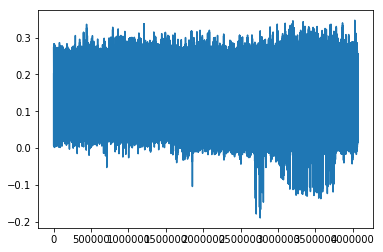

In [28]:
xplot = list(range(len(y)))
plt.plot(xplot, lrpredictions)
plt.show()

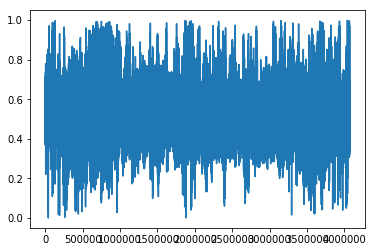

In [29]:
plt.plot(xplot, y)
plt.show()